In [1]:
import importlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline

import lib
import p3inn

importlib.reload(lib)
importlib.reload(p3inn)

<module 'p3inn' from '/Users/r/Documents/stud/ss24/finnpinn/src/p3inn/__init__.py'>

In [2]:
finn_out_path = Path("../data_out/finn/")

# Core 2

## Training

In [3]:
data_core2_df = lib.load_exp_data(name="Core 2")
conf_core2 = lib.load_exp_conf(name="Core 2")

data_core2b_df = lib.load_exp_data(name="Core 2B")
conf_core2b = lib.load_exp_conf(name="Core 2B")

In [4]:
finn_core2_dir = lib.FinnDir(finn_out_path / "core2")
# is_ok_to_delete = input(f"Remove {finn_core2_dir.path} (y/n)? ")
# if is_ok_to_delete == "y":
# shutil.rmtree(finn_core2_dir.path.absolute())
# finn_core2_dir = lib.FinnDir(finn_root / "core2")
np.save(finn_core2_dir.c_train_path, data_core2_df["c_diss"])
np.save(finn_core2_dir.t_train_path, data_core2_df["time"])
lib.finn_fit_retardation(
    out_dir=finn_core2_dir.path,
    is_exp_data=True,
    n_epochs=21,
    **conf_core2,
)

## Analysis

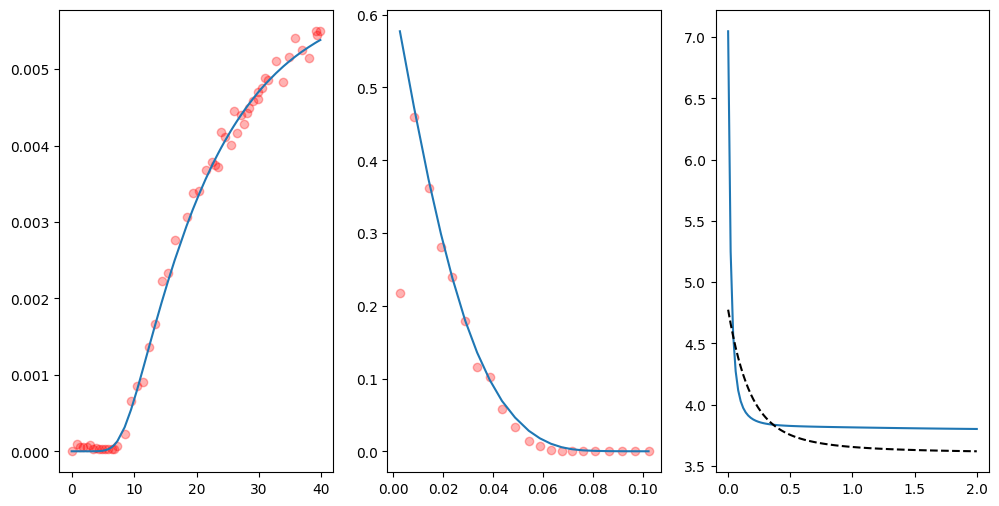

In [5]:
core2b_pred = lib.compute_core2B_profile(finn_core2_dir)

u = np.load(finn_core2_dir.u_ret_path)

n_epochs = finn_core2_dir.n_epochs
fig, axs = plt.subplots(ncols=3, figsize=(12, 6))

axs[0].scatter(data_core2_df["time"], data_core2_df["c_diss"], color="red", alpha=0.3)
axs[0].plot(
    data_core2_df["time"],
    np.load(finn_core2_dir.get_data_pred_path(n_epochs - 1)),
    zorder=10,
)

axs[1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], color="red", alpha=0.3)
axs[1].plot(data_core2b_df["x"], core2b_pred, zorder=10)

axs[2].plot(*finn_core2_dir.best_ret_points)
axs[2].plot(
    u,
    np.load(
        "/Users/r/Documents/dev/tmp/finn_with_julia/python/diffusion_sorption/experimental_data/learned_retardation.npy"
    ),
    "k--",
)
plt.show()

# FINN Results from P3INN PIs

In [7]:
finn_root = finn_out_path / "p3inn_core2_new_multiprocessing"
finn_dirs = list(map(lib.FinnDir, finn_root.iterdir()))
len(finn_dirs)

70

 93%|█████████▎| 65/70 [00:00<00:00, 211.68it/s]

[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.825/finn_loss.txt.npy'


100%|██████████| 70/70 [00:01<00:00, 40.66it/s] 


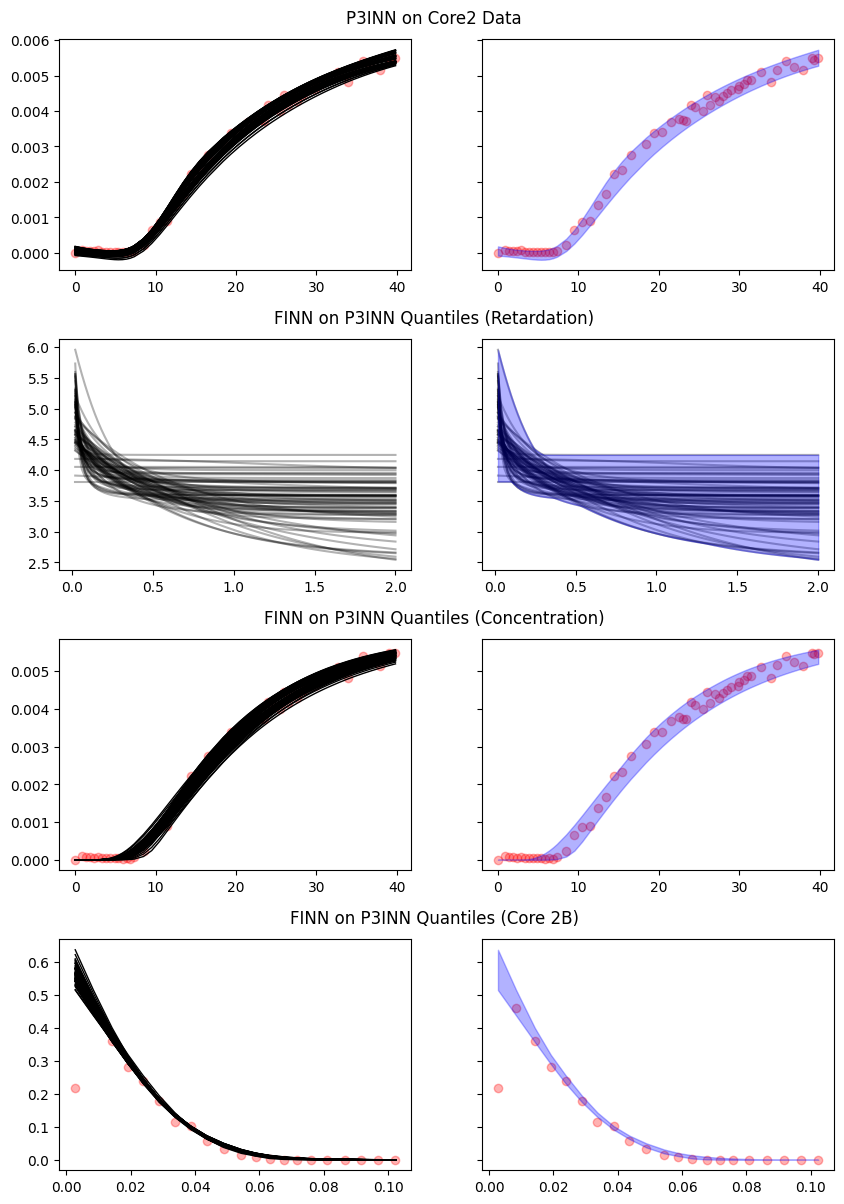

In [ ]:
import tqdm

data_core2_df = lib.load_exp_data("Core 2")
data_core2b_df = lib.load_exp_data("Core 2B")


data_kwargs = {"color": "red", "label": "Core2 Data", "alpha": 0.3, "edgecolor": None}
t_data = data_core2_df["time"]

# fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8, 10), sharey="row")
# axs[0, 0].set_title("P3INN on Core2 Data")
# axs[1, 0].set_title("FINN on P3INN Quantiles (Retardation)")
# axs[2, 0].set_title("FINN on P3INN Quantiles (Concentration)")
# axs[3, 0].set_title("FINN on P3INN Quantiles (Core 2B)")


# layout="constrained" was the problem causing non-alignment
fig = plt.figure(figsize=(10, 12))
subfigs = fig.subfigures(4, 1)
subfigs[0].suptitle("P3INN on Core2 Data")
subfigs[1].suptitle("FINN on P3INN Quantiles (Retardation)")
subfigs[2].suptitle("FINN on P3INN Quantiles (Concentration)")
subfigs[3].suptitle("FINN on P3INN Quantiles (Core 2B)")
axs = np.array([subfigs[i].subplots(1, 2, sharey=True) for i in range(4)])


for col in [0, 1]:
    axs[0, col].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)
    axs[2, col].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)
    axs[3, col].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)

all_core2_PIs_p3inn = []
all_core2_preds_finn = []
all_core2b_preds_finn = []
all_core1_preds_finn = []
all_rets = []
ret_samples_x = []
ret_samples_y = []


for finn_dir in tqdm.tqdm(finn_dirs):
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)

        t_eval = np.linspace(t_data.min(), t_data.max(), len(data))
        pred_data = np.interp(data_core2_df["time"], t_eval, np.load(finn_dir.get_data_pred_path(best_epoch)))
        data = np.interp(data_core2_df["time"], t_eval, np.load(finn_dir.c_train_path))
    except FileNotFoundError as e:
        print(e)
        continue

    pred_kwargs = {"color": "black", "zorder": 1, "alpha": 1.0, "lw": 1.0}
    if np.any(ret < 1) or np.any(ret > 100):
        print("Skipping", finn_dir)
        pred_kwargs["color"] = "red"
        pred_kwargs["zorder"] = 10
        pred_kwargs["lw"] = 3
        continue

    if finn_dir.core1_btc.exists():
        core1_c = np.load(finn_dir.core1_btc)
    else:
        core1_c = lib.compute_core1_btc(u_ret.squeeze(), ret.squeeze())
    np.save(finn_dir.core1_btc, core1_c)
    core2b_c = lib.compute_core2B_profile(finn_dir)

    all_core2_PIs_p3inn.append(data)
    all_core2_preds_finn.append(pred_data)
    all_core2b_preds_finn.append(core2b_c)
    all_core1_preds_finn.append(core1_c)
    all_rets.append(ret[1:].squeeze())
    ret_samples_x.append(u_ret[1:])
    ret_samples_y.append(ret[1:])

    axs[1, 0].plot(u_ret[1:], ret[1:], "k-", alpha=0.3)
    axs[1, 1].plot(u_ret[1:], ret[1:], "k-", alpha=0.3)
    axs[3, 0].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)
    axs[0, 0].plot(data_core2_df["time"], data, "-", **pred_kwargs)
    axs[2, 0].plot(data_core2_df["time"], pred_data, "-", **pred_kwargs)

all_core2_PIs_p3inn = np.array(all_core2_PIs_p3inn)
all_core2_preds_finn = np.array(all_core2_preds_finn)
all_core2b_preds_finn = np.array(all_core2b_preds_finn)
all_core1_preds_finn = np.array(all_core1_preds_finn)
all_rets = np.array(all_rets)
lib.ExperimentalSamples(
    core1=all_core1_preds_finn,
    core2=all_core2_preds_finn,
    core2b=all_core2b_preds_finn,
    ret_x=u_ret[1:],
    ret_y=all_rets,
).to_dir("../data_processed/experimental/DataSPAN")

ret_samples_x = np.concatenate(ret_samples_x)
ret_samples_y = np.concatenate(ret_samples_y)
ret_shuffle_indices = np.arange(len(ret_samples_x))
np.random.shuffle(ret_shuffle_indices)
ret_samples_x = ret_samples_x[ret_shuffle_indices]
ret_samples_y = ret_samples_y[ret_shuffle_indices]

# ========================================================================
# instead of taking the envelope of the rets, compute the PI via P3INN

# p3inn_dir_core2_rets = p3inn.P3innDir(Path("../data_out/p3inn/core2_rets"))
# p3inn_dir_core2_rets.x_data.save(ret_samples_x)
# p3inn_dir_core2_rets.y_data.save(ret_samples_y)
# p3inn.pi3nn_compute_PI_and_mean(p3inn_dir_core2_rets.path, [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55])

bound_upper_ret = np.max(all_rets, axis=0)
bound_lower_ret = np.min(all_rets, axis=0)
# bound_upper_ret = p3inn_dir_core2_rets.get_pred_bound_file(0.95, "up").load().squeeze()[:-1]
# bound_lower_ret = p3inn_dir_core2_rets.get_pred_bound_file(0.95, "down").load().squeeze()[:-1]
# ========================================================================

bound_upper_p3inn = np.max(all_core2_PIs_p3inn, axis=0)
bound_lower_p3inn = np.min(all_core2_PIs_p3inn, axis=0)
bound_upper_finn = np.max(all_core2_preds_finn, axis=0)
bound_lower_finn = np.min(all_core2_preds_finn, axis=0)
bound_upper_finn2b = np.max(all_core2b_preds_finn, axis=0)
bound_lower_finn2b = np.min(all_core2b_preds_finn, axis=0)

pi_kwargs = dict(color="blue", alpha=0.3, zorder=10)
axs[0, 1].fill_between(data_core2_df["time"], bound_lower_p3inn, bound_upper_p3inn, **pi_kwargs)
axs[1, 1].fill_between(
    u_ret[1:].squeeze(), bound_lower_ret, bound_upper_ret, **pi_kwargs
)
axs[2, 1].fill_between(data_core2_df["time"], bound_lower_finn, bound_upper_finn, **pi_kwargs)
axs[3, 1].fill_between(
    data_core2b_df["x"], bound_lower_finn2b, bound_upper_finn2b, **pi_kwargs
)

plt.show()

## Log-Likelihood

In [8]:
GIVEN_QUANTILE = 0.95

In [9]:
from dataclasses import dataclass


@dataclass
class LikelihoodResult:
    likelihood: np.ndarray
    sigmas: np.ndarray
    mean_gauss: np.ndarray
    bound_gauss_lower: np.ndarray
    bound_gauss_upper: np.ndarray

    def median_likelihood(self):
        return np.median(self.likelihood)

    def mean_likelihood(self, skip: int):
        return np.mean(self.likelihood[skip:])


def compute_loglikelihood_core2_normal(mean, upper, lower):
    # FIXME: Assumes 95% quantile is given
    # FINN paper has 95% PI -> 2.5% vals are below and 2.5% vals above
    c = -stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    sigmas = (upper - lower) / (2 * c)
    sigmas[sigmas < 1e-14] = 1e-14
    gauss_upper = mean + c * sigmas
    gauss_lower = mean - c * sigmas

    # interpolation needed because of data_core2_df["c_diss"]
    mean_intp = np.interp(t_data, t_eval, mean)
    sigmas_intp = np.interp(t_data, t_eval, sigmas)
    log_likeli = stats.norm.logpdf(
        data_core2_df["c_diss"], loc=mean_intp, scale=sigmas_intp
    )

    return LikelihoodResult(log_likeli, sigmas, mean, gauss_lower, gauss_upper)


def _fit_skewnorm(mean, upper, lower):
    from scipy.optimize import minimize

    # Step 1: Estimate scale from 95% CI
    z_2_5 = stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    z_97_5 = -stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    assert z_97_5 > 0
    scale = (upper - lower) / (z_97_5 - z_2_5)

    # Step 2: Function to minimize (to estimate skewness)
    def skewnorm_mse(a):
        # Use loc=mean and scale from CI
        dist = stats.skewnorm(a, loc=mean, scale=scale)
        # Compare the percentiles with given bounds
        ci_lower, ci_upper = dist.ppf([0.025, 0.975])
        # Compute the mean squared error
        return (ci_lower - lower) ** 2 + (ci_upper - upper) ** 2

    # Step 3: Estimate skewness (shape parameter 'a')
    result = minimize(skewnorm_mse, x0=0)
    a = result.x[0]

    # The fitted skew-normal distribution has parameters:
    skewnorm_params = {"a": a, "loc": mean, "scale": scale}
    return skewnorm_params


def compute_loglikelihood_core2_skewed(mean, upper, lower):
    params = [_fit_skewnorm(m, u, l) for m, u, l in zip(mean, upper, lower)]
    a = np.array([params[i]["a"] for i in range(len(params))])
    loc = np.array([params[i]["loc"] for i in range(len(params))])
    scale = np.array([params[i]["scale"] for i in range(len(params))])

    # FIXME: Assumes 95% quantile is given
    # FINN paper has 95% PI -> 2.5% vals are below and 2.5% vals above
    ci_lower = stats.skewnorm.ppf(0.025, a=a, loc=loc, scale=scale)
    ci_upper = stats.skewnorm.ppf(0.975, a=a, loc=loc, scale=scale)

    # interpolation needed because of data_core2_df["c_diss"]
    ap = np.interp(t_data, t_eval, a)
    locp = np.interp(t_data, t_eval, loc)
    scalep = np.interp(t_data, t_eval, scale)
    log_likeli = stats.skewnorm.logpdf(
        data_core2_df["c_diss"], a=ap, loc=locp, scale=scalep
    )

    return LikelihoodResult(log_likeli, scale, mean, ci_lower, ci_upper)


compute_loglikelihood_core2 = compute_loglikelihood_core2_normal  # _skewed

MCMC: 7.583481477429193 7.3794634225714395
FINN: 7.486316880011858 7.418778760026356


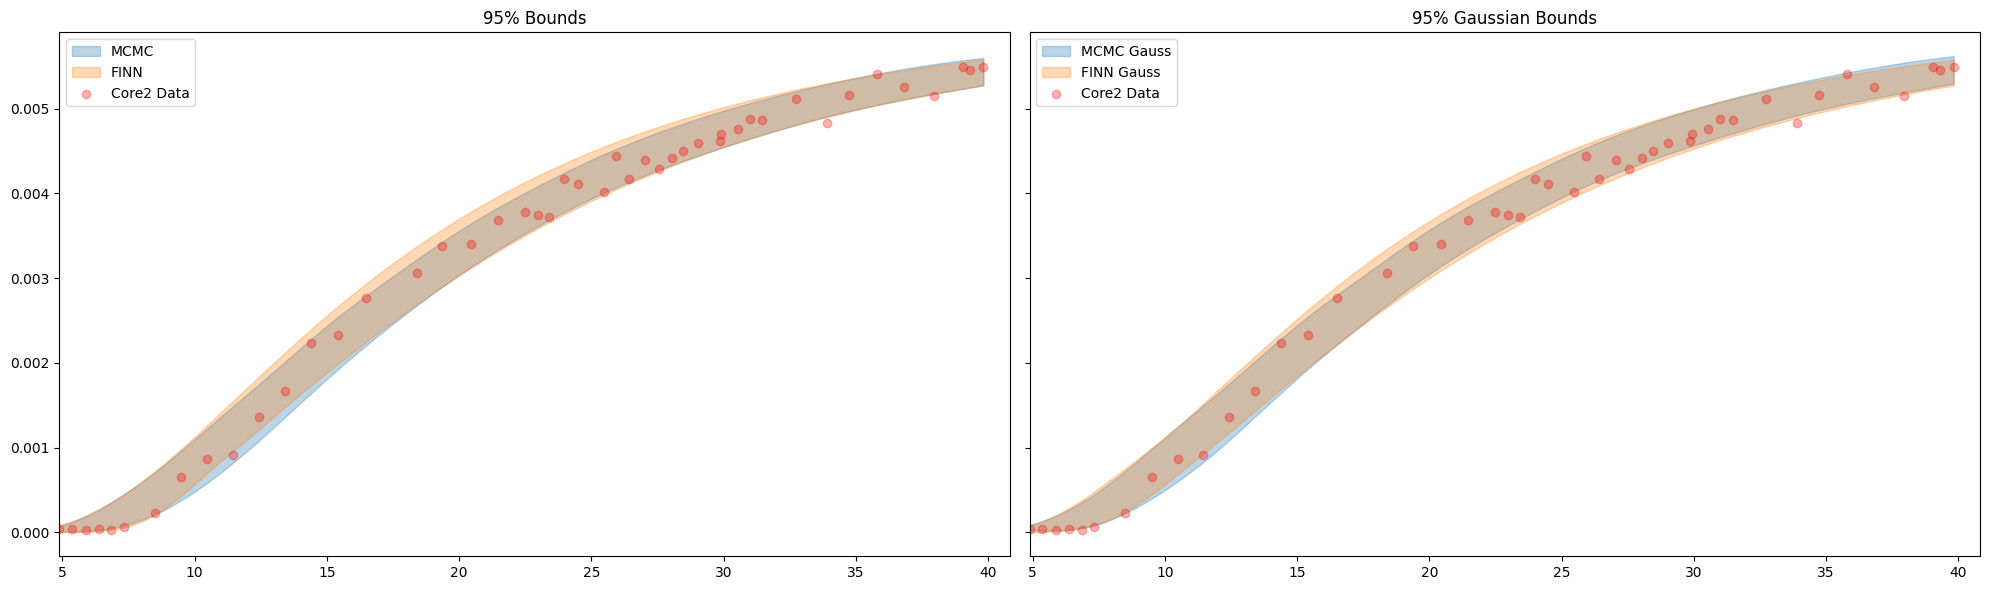

In [10]:
# MCMC Paper ----------------------------------------
mean_core2_df = (
    pd.read_csv("../data/digitized/mean_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
mean_core2_df["y"] /= 1000
upper_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/upper_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
upper_mcmc_PI_core2_df["y"] /= 1000
lower_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/lower_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
lower_mcmc_PI_core2_df["y"] /= 1000


mean_core2_paper = UnivariateSpline(mean_core2_df["x"], mean_core2_df["y"], s=0.0)(
    t_eval
)
upper_mcmc_PI_core2 = UnivariateSpline(
    upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)
lower_mcmc_PI_core2 = UnivariateSpline(
    lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)

loglikeli_result_mcmc = compute_loglikelihood_core2(
    mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2
)

# FINN ----------------------------------------
mean_core2_preds_finn = np.mean(all_core2_preds_finn, axis=0)
loglikeli_result_finn = compute_loglikelihood_core2(
    mean_core2_preds_finn, bound_upper_finn, bound_lower_finn
)

fig, axs = plt.subplots(ncols=2, figsize=(20, 6), sharey=True)
# check that spline interpolation works
# plt.plot(lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(mean_core2_df["x"], mean_core2_df["y"], "b-o")
# plt.plot(t_eval, mean_core2_paper)
# plt.plot(t_eval, upper_mcmc_PI_core2)
# plt.plot(t_eval, lower_mcmc_PI_core2)

SKIP = 9

axs[0].set_title("95% Bounds")
axs[0].fill_between(
    t_eval,
    lower_mcmc_PI_core2,
    upper_mcmc_PI_core2,
    alpha=0.3,
    color="C0",
    label="MCMC",
)
axs[0].fill_between(
    t_eval, bound_lower_finn, bound_upper_finn, alpha=0.3, color="C1", label="FINN"
)

axs[0].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[0].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[0].legend()


axs[1].set_title("95% Gaussian Bounds")
axs[1].fill_between(
    t_eval,
    loglikeli_result_mcmc.bound_gauss_lower,
    loglikeli_result_mcmc.bound_gauss_upper,
    alpha=0.3,
    color="C0",
    label="MCMC Gauss",
)
axs[1].fill_between(
    t_eval,
    loglikeli_result_finn.bound_gauss_lower,
    loglikeli_result_finn.bound_gauss_upper,
    alpha=0.3,
    color="C1",
    label="FINN Gauss",
)
axs[1].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[1].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[1].legend()


print(
    "MCMC:",
    loglikeli_result_mcmc.median_likelihood(),
    loglikeli_result_mcmc.mean_likelihood(skip=SKIP),
)
print(
    "FINN:",
    loglikeli_result_finn.median_likelihood(),
    loglikeli_result_finn.mean_likelihood(skip=SKIP),
)

plt.tight_layout()
plt.show()

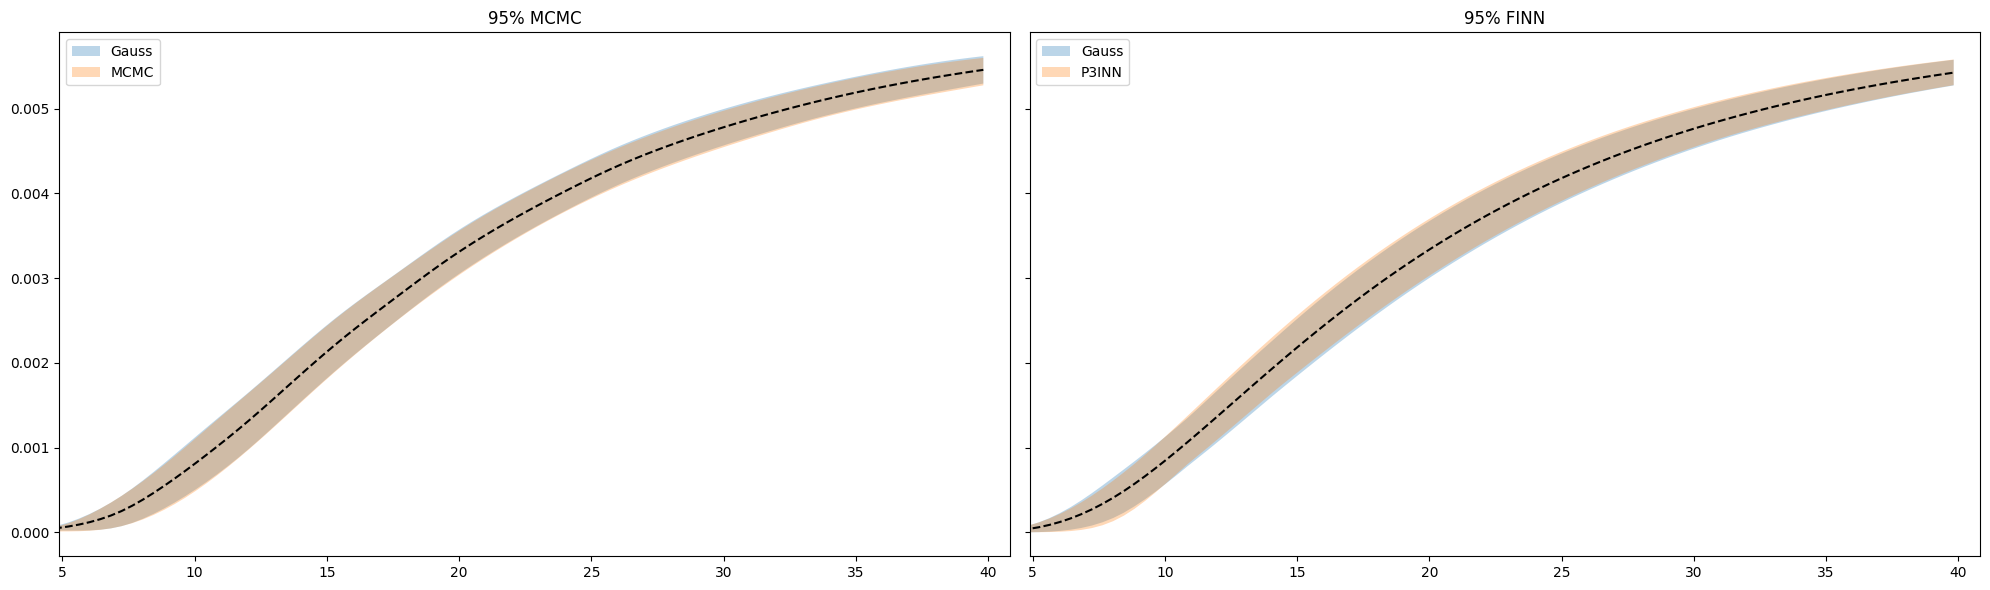

In [11]:
# MCMC Paper ----------------------------------------
mean_core2_df = (
    pd.read_csv("../data/digitized/mean_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
mean_core2_df["y"] /= 1000
upper_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/upper_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
upper_mcmc_PI_core2_df["y"] /= 1000
lower_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/lower_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
lower_mcmc_PI_core2_df["y"] /= 1000


mean_core2_paper = UnivariateSpline(mean_core2_df["x"], mean_core2_df["y"], s=0.0)(
    t_eval
)
upper_mcmc_PI_core2 = UnivariateSpline(
    upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)
lower_mcmc_PI_core2 = UnivariateSpline(
    lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)

loglikeli_result_mcmc = compute_loglikelihood_core2(
    mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2
)

# FINN ----------------------------------------
mean_core2_preds_finn = np.mean(all_core2_preds_finn, axis=0)
loglikeli_result_finn = compute_loglikelihood_core2(
    mean_core2_preds_finn, bound_upper_finn, bound_lower_finn
)

fig, axs = plt.subplots(ncols=2, figsize=(20, 6), sharey=True)
# check that spline interpolation works
# plt.plot(lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(mean_core2_df["x"], mean_core2_df["y"], "b-o")
# plt.plot(t_eval, mean_core2_paper)
# plt.plot(t_eval, upper_mcmc_PI_core2)
# plt.plot(t_eval, lower_mcmc_PI_core2)

SKIP = 9

axs[0].set_title("95% MCMC")
axs[0].plot(t_eval, loglikeli_result_mcmc.mean_gauss, "k--")
axs[0].fill_between(
    t_eval,
    loglikeli_result_mcmc.bound_gauss_lower,
    loglikeli_result_mcmc.bound_gauss_upper,
    alpha=0.3,
    label="Gauss",
)
axs[0].fill_between(
    t_eval, lower_mcmc_PI_core2, upper_mcmc_PI_core2, alpha=0.3, label="MCMC"
)
# axs[0].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[0].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[0].legend()


axs[1].set_title("95% FINN")
axs[1].plot(t_eval, loglikeli_result_finn.mean_gauss, "k--")
axs[1].fill_between(
    t_eval,
    loglikeli_result_finn.bound_gauss_lower,
    loglikeli_result_finn.bound_gauss_upper,
    alpha=0.3,
    label="Gauss",
)
axs[1].fill_between(
    t_eval, bound_lower_finn, bound_upper_finn, alpha=0.3, label="P3INN"
)
# axs[1].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[1].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[1].legend()

plt.tight_layout()
plt.show()

# Appendix

## All FINN predictions for PI3NN PIs separately

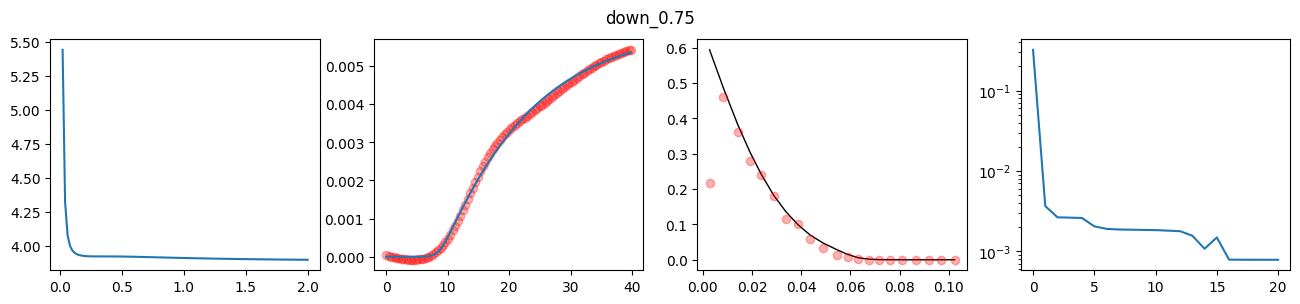

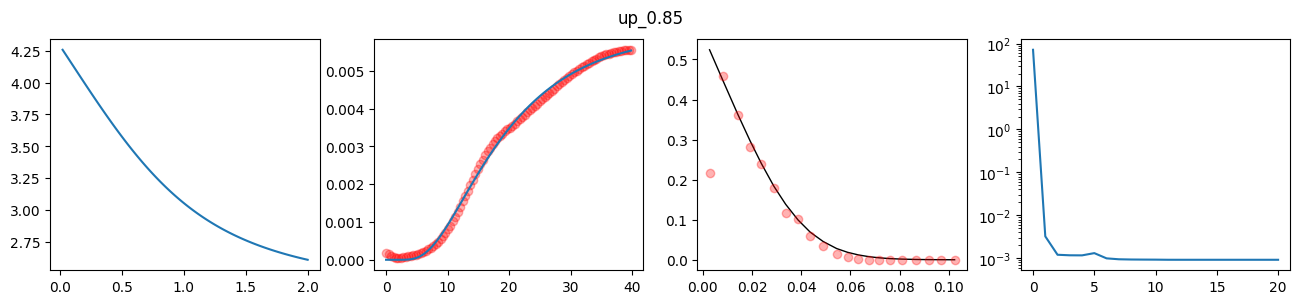

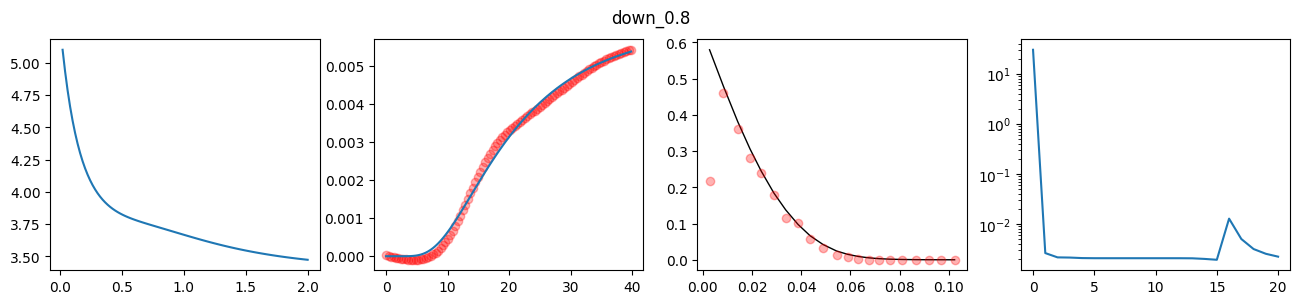

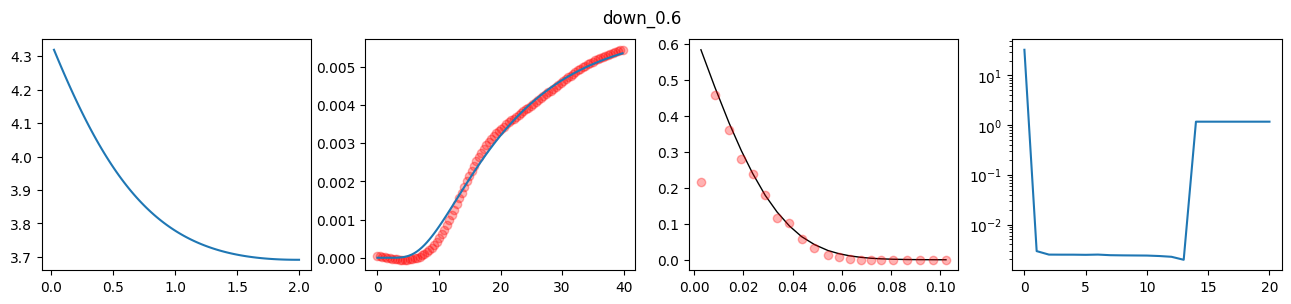

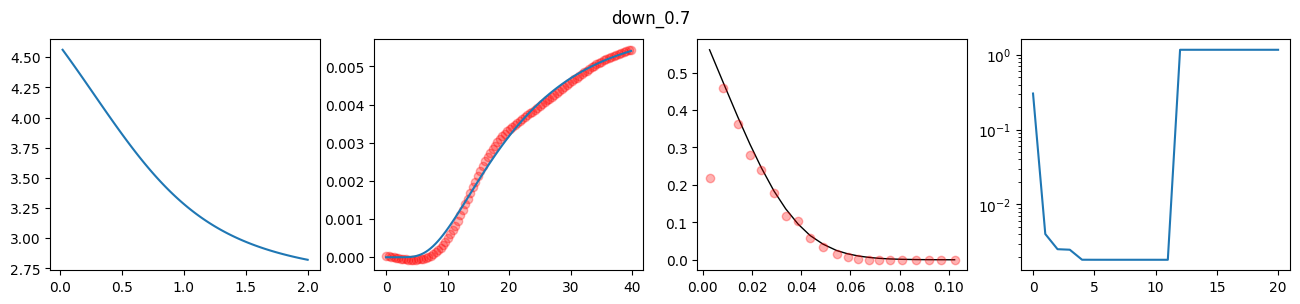

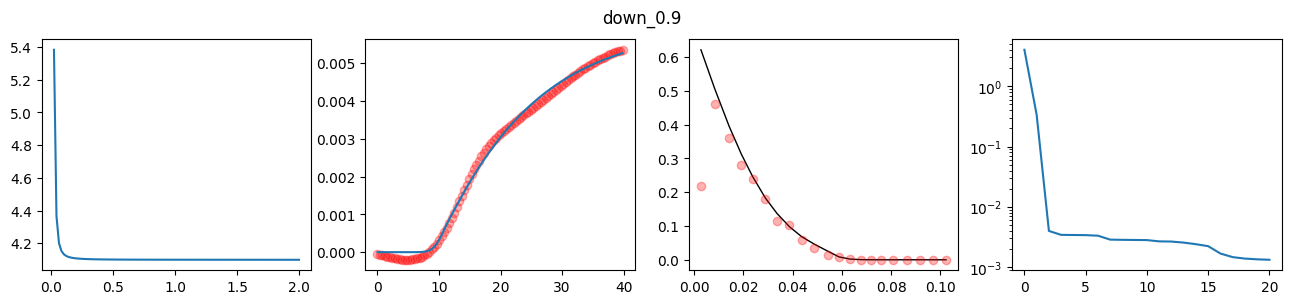

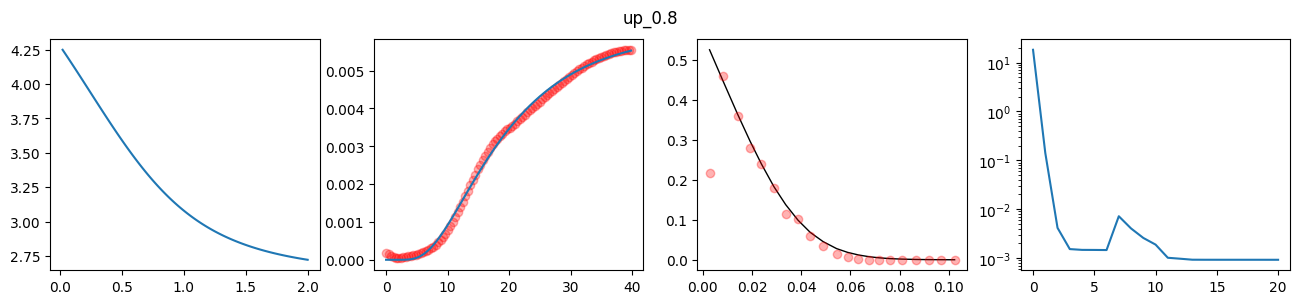

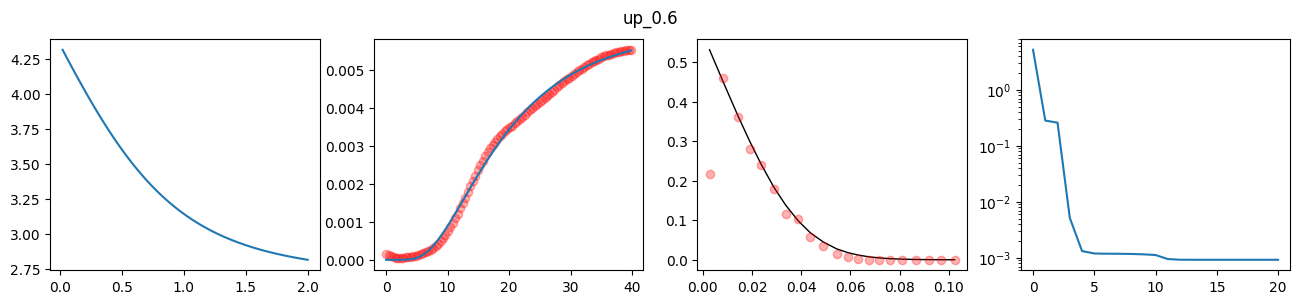

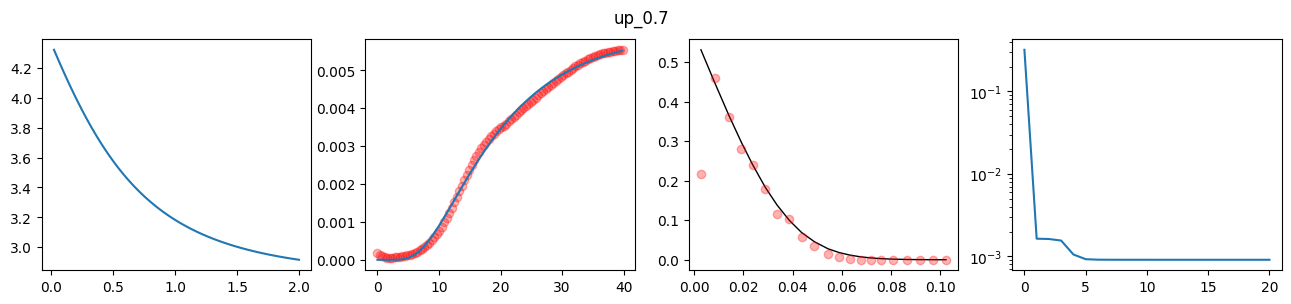

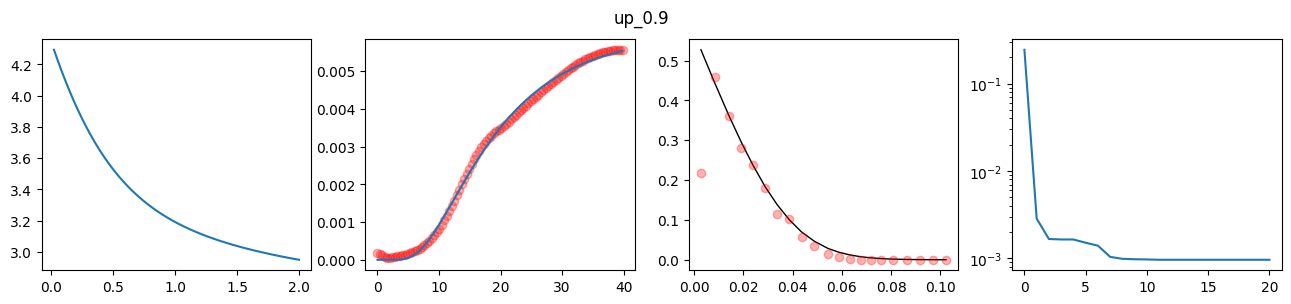

Skipping due to dt = 0 FinnDir(path=PosixPath('../data_out/finn/p3inn_core2_new_multiprocessing/down_0.95'))


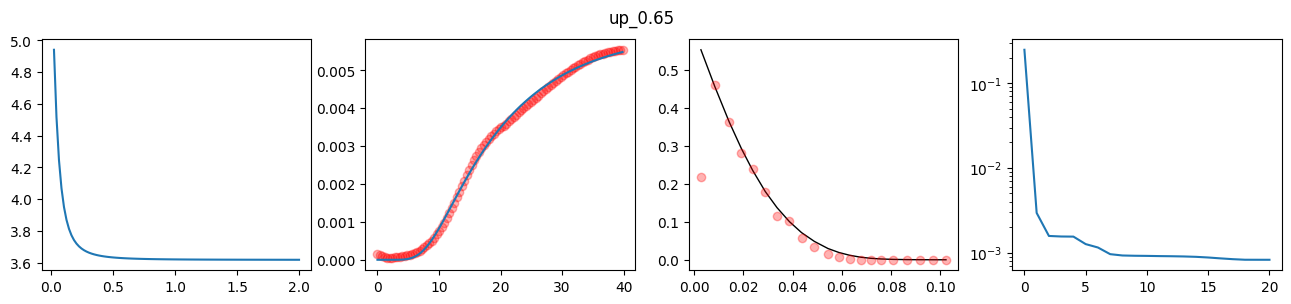

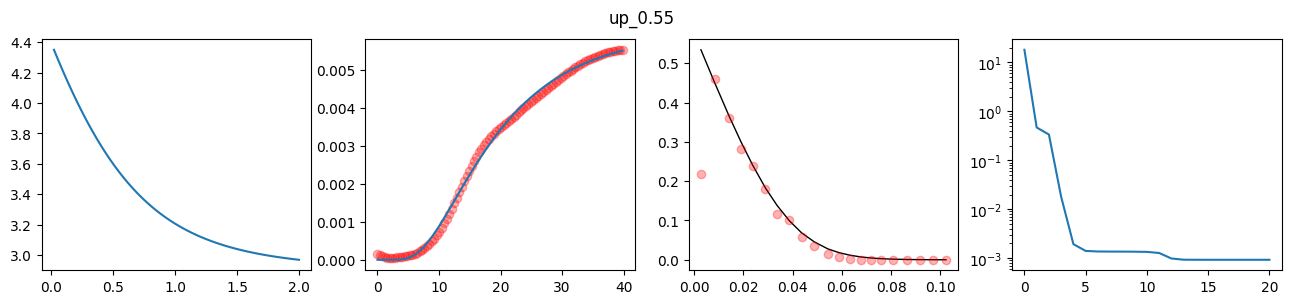

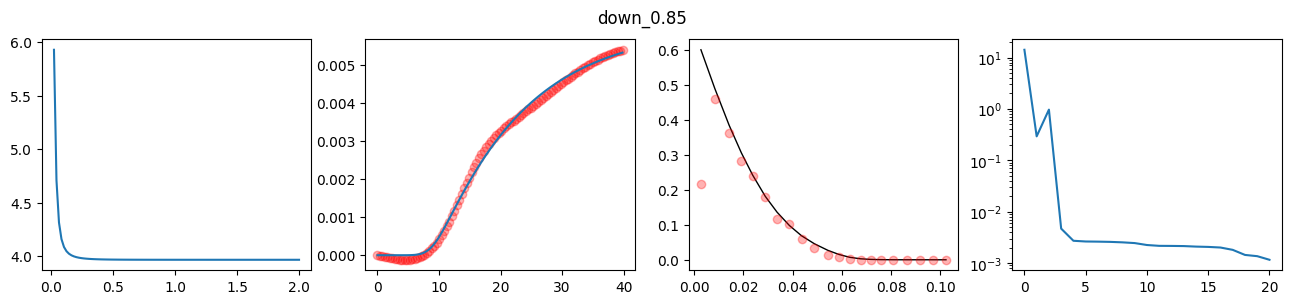

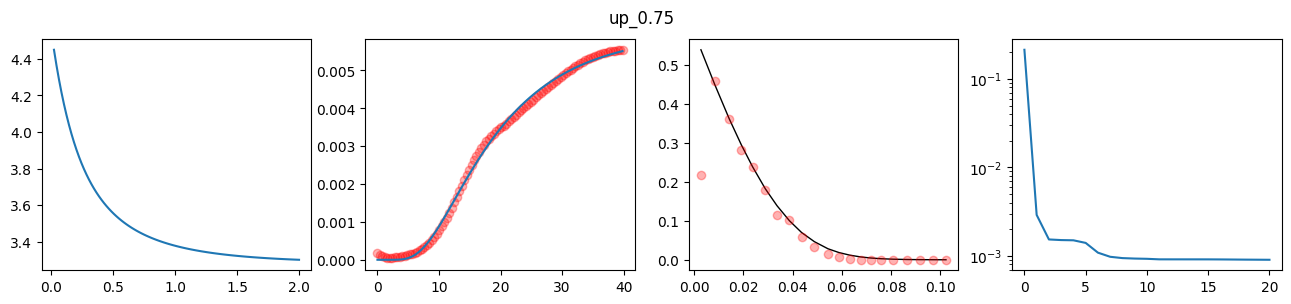

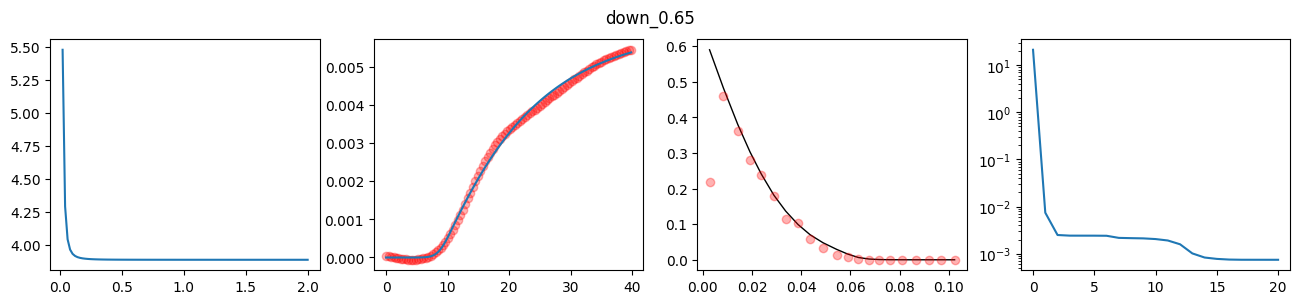

[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.95/finn_loss.txt.npy'


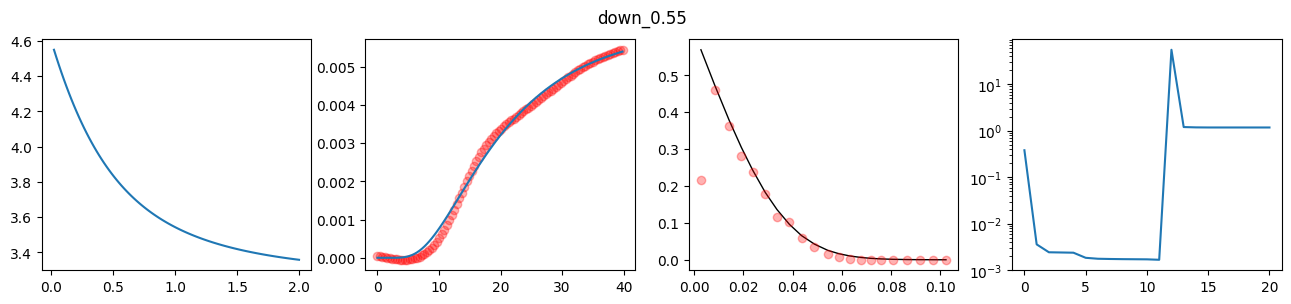

In [16]:
for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    try:
        core2b_c = lib.compute_core2B_profile(finn_dir)
    except AssertionError:
        print("Skipping due to dt = 0", finn_dir)
        continue

    fig, axs = plt.subplots(ncols=4, figsize=(16, 3))
    fig.suptitle(f"{finn_dir.path.name}")

    axs[0].plot(u_ret[1:], ret[1:])

    axs[1].scatter(t_eval, data, **data_kwargs)
    axs[1].plot(t_eval, pred_data, "-")

    axs[2].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)
    axs[2].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)

    axs[3].semilogy(loss, "-")

    plt.show()